As always, all the necessary libararies are first imported before mounting the drive to the notebook.

In [2]:
!pip install import_ipynb

from IPython.display import clear_output
clear_output()

In [3]:
import torch
import matplotlib.pyplot as plt
import cv2
import PIL
import numpy as np
from torch import nn
import torchvision
from torchvision import transforms
from PIL import Image
import random
import import_ipynb

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/Object_detection

from utils import calculate_iou

%cd /content/

/content/drive/MyDrive/Object_detection
/content


The saved model and the test folder paths are to be saved in a string to use them as and when required.

In [7]:
test_folder_path = 'drive/MyDrive/Object_detection/Test_images'
model_path = '/content/drive/MyDrive/Object_detection/resnet_model.pt'

model = torch.load(model_path)

When passsing a test image, the image is first to be processed through Selective Search Segmentation to generate Region Proposals. Each of these Region Proposals are then passed to the trained model and the model returns a probability score, but only those Region Proposals are saved whose scores are greater than a certain threshold.

These saved bounding boxes are then subjected to bounding box regression. Both these tasks are achieved by these following functions:


In [8]:
def propose_bounding_boxes(img_path: str, model: torchvision.models.resnet.ResNet, threshold_probability = 0.9) -> tuple([list, list]):
  '''
  Function Description:
    Takes in path to an image as a string, a model along with a threshold probability. Runs selective search segmentation on the image, passes each of the Regions Of Interest produced to the
    model. The model then returns the scores for each of the ROIs, and the function returns all the bounding boxes whose scores are greater than threshold_probability.

  Parameters:
    img_path: path to an image
    threshold_probability: cut-off probability to save region proposals

  Returns:
    A tuple of 2 lists: bounding boxes and probability scores
  '''
  img = plt.imread(img_path)
  proposed_bounding_boxes_list = []
  scores = []
  
  # Using cuda if available
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model.to(device)
  
  # image_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
  image_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

  softmax = nn.Softmax(dim = 1)
  model.eval()


  # Running the selective search algorithm on the image to propose around 2000 - 3000 bounding boxes
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(img)
  ss.switchToSelectiveSearchFast()
  rects = ss.process()

  for rect in rects:
    x, y, w, h = rect
    cropped_img = img[y:y+h, x:x+w, :]
    cropped_img = cv2.resize(cropped_img, (224,224), interpolation = cv2.INTER_AREA)

    if(x+w < img.shape[1] and y+h < img.shape[0]):
      # Image transforms can be applied to a single image only by converting the image to a PIL image:
      pil_image = Image.fromarray(cropped_img)
      cropped_img = image_transform(pil_image)
      cropped_img = cropped_img[None, :]
      cropped_img = cropped_img.to(device)       

      # The output from the model after passing the cropped image into it is passed through the softmax function to get probability values
      logits = softmax(model(cropped_img))

      # Plotting the rectangle only if the probability > threshold_probability
      if(logits[0][1] > threshold_probability):
        proposed_bounding_boxes_list.append(list(rect))
        scores.append(np.round(logits[0][1].item(), 2))
        

  return proposed_bounding_boxes_list, scores

In [9]:
def non_max_suppression(img_path: str, proposed_bounding_boxes_list: list, scores: list, threshold_iou: int = 0.5) -> list:
  '''
  Function Description:
    Takes in path to an image and lists of bounding box values and corresponding scores and returns a subset of bounding boxes after suppressing a few overlapping ones based on the passed threshold Intersection
    Over Union (IOU).

  Parameters:
    proposed_bounding_boxes_list: list of proposed bounding box values
    scores: corresponding propability scores of bounding boxes 
    threshold_iou: cut-off iou to eliminate one of 2 overlapping bounding boxes

  Returns:
    a list of tuples containing bounding box values and corresponding scores after applying non-max suppression.  
  '''
  keepers = []
  bbox_and_scores = list(list(i) for i in zip(proposed_bounding_boxes_list, scores))

  len_bbox_and_scores = len(bbox_and_scores)

  while(len_bbox_and_scores != 0):
    
    bbox_with_max_score = max(bbox_and_scores, key = lambda x: x[1])
    keepers.append(bbox_with_max_score)
    bbox_and_scores.remove(bbox_with_max_score)

    for (bbox, score) in bbox_and_scores:
      iou = calculate_iou(bbox, bbox_with_max_score[0])

      if (iou > threshold_iou):
        bbox_and_scores.remove([bbox, score])
    
    len_bbox_and_scores = len(bbox_and_scores)

    img = plt.imread(img_path)
    for ((x, y, w, h), score) in bbox_and_scores:
      r = random.randint(0, 256)
      g = random.randint(0, 256)
      b = random.randint(0, 256)
    
      cv2.rectangle(img, (x, y), (x+w, y+h), (r, g, b), 5)

  print(plt.imshow(img))

    # if(len_bbox_and_scores == old_len_bbox_and_scores):
      # # keepers.extend(bbox_and_scores)
      # print('ending now')
      # bbox_and_scores.clear()
      # len_bbox_and_scores = 0

    # print(len_bbox_and_scores)

  return keepers

In [10]:
def person_detection(img_path: str) -> None:
  '''
  Function Description:
    Takes in path to an image and prints the image along with the bounding boxes after running the image through Selective Search Segmentation and through Non Max Suppression.\
    Also, prints the number of bounding boxes and their scores after every iteration of applying NMS.

  Parameters:
    img_path: path to the image to be processed

  Prints the image and bounding boxes after applying non max suppression iteratively.
  '''
  
  img = plt.imread(img_path)

  bounding_boxes, scores = propose_bounding_boxes(img_path, model, threshold_probability = 0.75)
  print('Number of proposed bounding boxes: ', len(bounding_boxes))
  old_len_bboxes = -1
  new_len_bboxes = len(bounding_boxes)
  count = 0

  while(new_len_bboxes != old_len_bboxes):
    count += 1
    bboxes_after_nms = non_max_suppression(img_path, bounding_boxes, scores, threshold_iou = 0.6)
    print(f'Non-Max Suppression iteration number: {count}, bounding boxes left: {len(bboxes_after_nms)}')
    
    bboxes = [x[0] for x in bboxes_after_nms]
    scores = [x[1] for x in bboxes_after_nms]

    print(scores, '\n')

    old_len_bboxes = new_len_bboxes
    new_len_bboxes = len(bboxes)


  for ((x, y, w, h), score) in bboxes_after_nms:
    r = random.randint(0, 256)
    g = random.randint(0, 256)
    b = random.randint(0, 256)
    
    cv2.rectangle(img, (x, y), (x+w, y+h), (r, g, b), 5)
    # cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 3)

  plt.imshow(img)
  plt.show()

Let's finally pass in a few images to see how the model performs..

Number of proposed bounding boxes:  65
AxesImage(54,36;334.8x217.44)
NMS 1, number of bounding boxes: 14
[0.93, 0.92, 0.92, 0.9, 0.87, 0.86, 0.86, 0.84, 0.83, 0.83, 0.83, 0.82, 0.8, 0.78] 

AxesImage(54,36;334.8x217.44)
NMS 2, number of bounding boxes: 8
[0.93, 0.92, 0.9, 0.87, 0.86, 0.86, 0.83, 0.8] 

AxesImage(54,36;334.8x217.44)
NMS 3, number of bounding boxes: 6
[0.93, 0.9, 0.87, 0.86, 0.86, 0.83] 

AxesImage(54,36;334.8x217.44)
NMS 4, number of bounding boxes: 5
[0.93, 0.87, 0.86, 0.86, 0.83] 

AxesImage(54,36;334.8x217.44)
NMS 5, number of bounding boxes: 4
[0.93, 0.86, 0.86, 0.83] 

AxesImage(54,36;334.8x217.44)
NMS 6, number of bounding boxes: 3
[0.93, 0.86, 0.83] 

AxesImage(54,36;334.8x217.44)
NMS 7, number of bounding boxes: 2
[0.93, 0.83] 

AxesImage(54,36;334.8x217.44)
NMS 8, number of bounding boxes: 1
[0.93] 

AxesImage(54,36;334.8x217.44)
NMS 9, number of bounding boxes: 1
[0.93] 



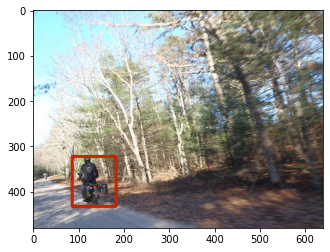

In [ ]:
img_path = (test_folder_path + '/000000000979.jpg')

person_detection(img_path)

Number of proposed bounding boxes:  38
AxesImage(54,36;334.8x217.44)
NMS 1, number of bounding boxes: 13
[0.9, 0.89, 0.89, 0.86, 0.85, 0.84, 0.82, 0.81, 0.79, 0.78, 0.77, 0.77, 0.76] 

AxesImage(54,36;334.8x217.44)
NMS 2, number of bounding boxes: 10
[0.9, 0.89, 0.86, 0.85, 0.84, 0.82, 0.81, 0.79, 0.78, 0.76] 

AxesImage(54,36;334.8x217.44)
NMS 3, number of bounding boxes: 9
[0.9, 0.89, 0.85, 0.84, 0.82, 0.81, 0.79, 0.78, 0.76] 

AxesImage(54,36;334.8x217.44)
NMS 4, number of bounding boxes: 8
[0.9, 0.89, 0.84, 0.82, 0.81, 0.79, 0.78, 0.76] 

AxesImage(54,36;334.8x217.44)
NMS 5, number of bounding boxes: 7
[0.9, 0.89, 0.82, 0.81, 0.79, 0.78, 0.76] 

AxesImage(54,36;334.8x217.44)
NMS 6, number of bounding boxes: 6
[0.9, 0.89, 0.81, 0.79, 0.78, 0.76] 

AxesImage(54,36;334.8x217.44)
NMS 7, number of bounding boxes: 5
[0.9, 0.89, 0.79, 0.78, 0.76] 

AxesImage(54,36;334.8x217.44)
NMS 8, number of bounding boxes: 4
[0.9, 0.89, 0.78, 0.76] 

AxesImage(54,36;334.8x217.44)
NMS 9, number of boun

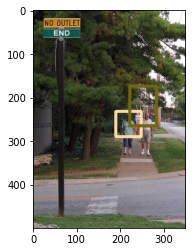

In [ ]:
img_path = (test_folder_path + '/000000000448.jpg')

person_detection(img_path)

Number of proposed bounding boxes:  55
AxesImage(54,36;334.8x217.44)
NMS 1, number of bounding boxes: 14
[0.95, 0.95, 0.93, 0.9, 0.9, 0.9, 0.88, 0.86, 0.86, 0.82, 0.79, 0.77, 0.77, 0.75] 

AxesImage(54,36;334.8x217.44)
NMS 2, number of bounding boxes: 6
[0.95, 0.93, 0.9, 0.9, 0.82, 0.79] 

AxesImage(54,36;334.8x217.44)
NMS 3, number of bounding boxes: 4
[0.95, 0.9, 0.9, 0.79] 

AxesImage(54,36;334.8x217.44)
NMS 4, number of bounding boxes: 3
[0.95, 0.9, 0.79] 

AxesImage(54,36;334.8x217.44)
NMS 5, number of bounding boxes: 2
[0.95, 0.79] 

AxesImage(54,36;334.8x217.44)
NMS 6, number of bounding boxes: 1
[0.95] 

AxesImage(54,36;334.8x217.44)
NMS 7, number of bounding boxes: 1
[0.95] 



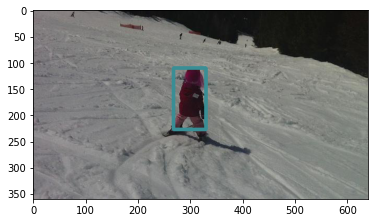

In [ ]:
img_path = (test_folder_path + '/000000000408.jpg')

person_detection(img_path)

Number of proposed bounding boxes:  13
AxesImage(54,36;334.8x217.44)
Non-Max Suppression iteration number: 1, bounding boxes left: 6
[0.87, 0.84, 0.81, 0.81, 0.78, 0.75] 

AxesImage(54,36;334.8x217.44)
Non-Max Suppression iteration number: 2, bounding boxes left: 3
[0.87, 0.81, 0.78] 

AxesImage(54,36;334.8x217.44)
Non-Max Suppression iteration number: 3, bounding boxes left: 2
[0.87, 0.78] 

AxesImage(54,36;334.8x217.44)
Non-Max Suppression iteration number: 4, bounding boxes left: 1
[0.87] 

AxesImage(54,36;334.8x217.44)
Non-Max Suppression iteration number: 5, bounding boxes left: 1
[0.87] 



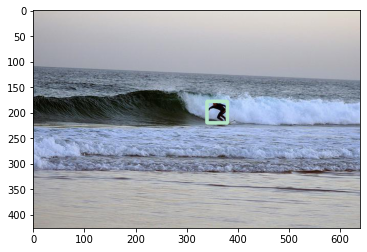

In [13]:
img_path = (test_folder_path + '/000000000251.jpg')

person_detection(img_path)

As seen, the object detection model doesn't always produce consistent results but with the limited GPU resources that Google Colab offered, the resnet model could only be trained on so many images.

If two persons stood very close to each other in an image, the model can either put one of the two people or put one big box around both the people. This is one of the drawbacks of using R-CNNs for object detection.


This project was built over 5 weeks as this was my first major project and feedbacks are always welcome. There are tens of ways to improve this project that I can think of, and I look forward to exhibit all the work on my GitHub.

Thanks for reading!